## 1. Import Libraries & Setup

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import time
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("Setup complete!")

Setup complete!


## 2. Data Loading & Exploration

Using dataset: WELFake_Dataset.csv
Real samples: 37106 | Fake samples: 35028


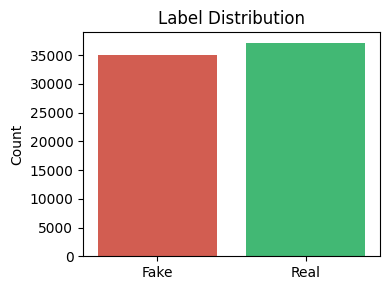

Missing values:
Unnamed: 0      0
title         558
text           39
label           0
full_text       0
dtype: int64

Dataset: 72134 articles | Real: 37106 | Fake: 35028


In [2]:
# Load datasets
# real_news = pd.read_csv('True.csv')
# fake_news = pd.read_csv('Fake.csv')

# real_news['label'] = 1
# fake_news['label'] = 0
# Toggle to switch between original dataset (True/Fake) and WELFake
USE_WELFAKE = True  # set to True to load WELFake_Dataset.csv

if USE_WELFAKE:
    # ---------------- WELFake ----------------
    df_raw = pd.read_csv('WELFake_Dataset.csv')

    # Ensure correct label column
    if 'news_label' in df_raw.columns:
        df_raw = df_raw.rename(columns={'news_label': 'label'})

    required_cols = ['title', 'text', 'label']
    missing_cols = [c for c in required_cols if c not in df_raw.columns]
    if missing_cols:
        raise ValueError(f"WELFake_Dataset.csv missing columns: {missing_cols}")

    real_news = df_raw[df_raw['label'] == 1].copy()
    fake_news = df_raw[df_raw['label'] == 0].copy()

    dataset_name = "WELFake_Dataset.csv"

else:
    # ---------------- True / Fake ----------------
    real_news = pd.read_csv('True.csv')
    fake_news = pd.read_csv('Fake.csv')

    # Add labels
    real_news['label'] = 1
    fake_news['label'] = 0

    # Keep only needed columns
    required_cols = ['title', 'text', 'label']
    real_news = real_news[required_cols]
    fake_news = fake_news[required_cols]

    dataset_name = "True.csv + Fake.csv"

# ---------------- Common Processing ----------------
print(f"Using dataset: {dataset_name}")
print(f"Real samples: {len(real_news)} | Fake samples: {len(fake_news)}")

# Combine & shuffle
df = pd.concat([real_news, fake_news], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create full text
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

# ---------------- Visualization ----------------
label_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(4, 3))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    palette=['#e74c3c', '#2ecc71']
)
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title('Label Distribution')
plt.ylabel('Count')
plt.xlabel('')
plt.tight_layout()
plt.show()

# ---------------- Info ----------------
print("Missing values:")
print(df.isnull().sum())
print(f"\nDataset: {len(df)} articles | Real: {df['label'].sum()} | Fake: {len(df) - df['label'].sum()}")


### Data Visualization

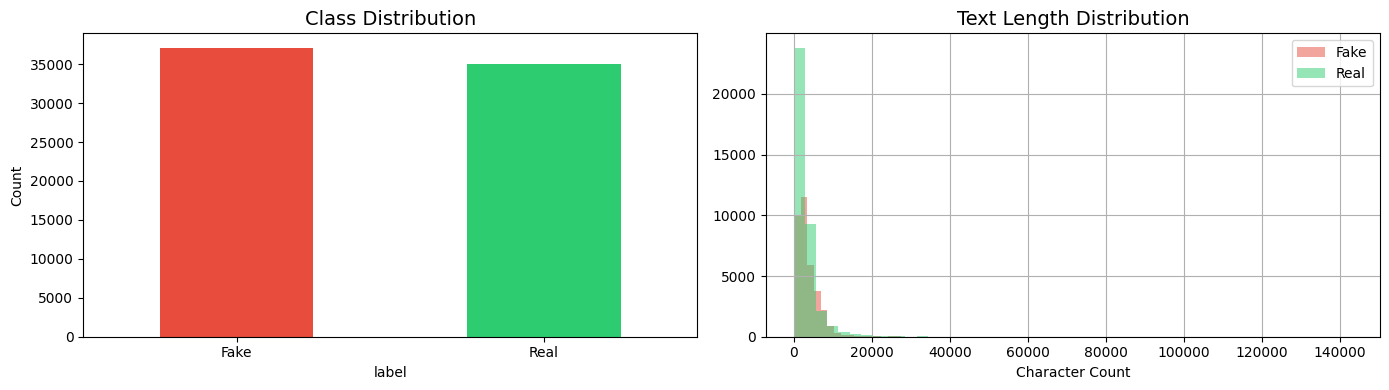

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Class distribution
colors = ['#e74c3c', '#2ecc71']
df['label'].value_counts().plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Class Distribution', fontsize=14)
axes[0].set_xticklabels(['Fake', 'Real'], rotation=0)
axes[0].set_ylabel('Count')

# Text length distribution
df['text_length'] = df['full_text'].apply(len)
df[df['label']==0]['text_length'].hist(bins=50, alpha=0.5, label='Fake', ax=axes[1], color='#e74c3c')
df[df['label']==1]['text_length'].hist(bins=50, alpha=0.5, label='Real', ax=axes[1], color='#2ecc71')
axes[1].set_title('Text Length Distribution', fontsize=14)
axes[1].set_xlabel('Character Count')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [4]:
# Train-Test Split (80-20)
X = df['full_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test)} samples")

Training Set: 57707 samples
Testing Set: 14427 samples


In [5]:
# Text Preprocessing Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocess text: lowercase, remove URLs, HTML, special chars, stopwords, lemmatize"""
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    
    return ' '.join(tokens)

print("Preprocessing training data...")
X_train_processed = X_train.apply(preprocess_text)
print("Preprocessing testing data...")
X_test_processed = X_test.apply(preprocess_text)
print("Preprocessing complete!")

Preprocessing training data...
Preprocessing testing data...
Preprocessing complete!


## 4. TF-IDF Vectorization
Convert text to numerical features for traditional ML models

In [6]:
# TF-IDF Vectorizer
# Further trimmed to reduce memory footprint during fit
# and keep matrices in float32 for downstream models.
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 1),
    min_df=10,
    max_df=0.8,
)

X_train_tfidf = tfidf.fit_transform(X_train_processed).astype(np.float32)
X_test_tfidf = tfidf.transform(X_test_processed).astype(np.float32)

print(f"TF-IDF Features: {X_train_tfidf.shape[1]}")

TF-IDF Features: 5000


---
## 5. Model Training & Evaluation
Training 6 traditional ML models + 1 optimized BERT model

In [7]:
# Dictionary to store results
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, train_time):
    """Evaluate model and store results"""
    y_pred = model.predict(X_test)
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'train_time': train_time,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"\n{'='*60}")
    print(f"{name.upper()}")
    print(f"{'='*60}")
    print(f"Training Time: {train_time:.2f}s")
    print(f"Accuracy:      {results[name]['accuracy']:.4f} ({results[name]['accuracy']*100:.2f}%)")
    print(f"Precision:     {results[name]['precision']:.4f}")
    print(f"Recall:        {results[name]['recall']:.4f}")
    print(f"F1-Score:      {results[name]['f1']:.4f}")

### Model 1: Logistic Regression

In [8]:
print("Training Logistic Regression...")
start_time = time.time()
lr_model = LogisticRegression(max_iter=200, random_state=42, n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Logistic Regression', lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Logistic Regression...

LOGISTIC REGRESSION
Training Time: 1.00s
Accuracy:      0.9497 (94.97%)
Precision:     0.9484
Recall:        0.9542
F1-Score:      0.9513


### Model 2: Naive Bayes (Multinomial)

In [9]:
print("Training Naive Bayes...")
start_time = time.time()
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Naive Bayes', nb_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Naive Bayes...

NAIVE BAYES
Training Time: 0.06s
Accuracy:      0.8424 (84.24%)
Precision:     0.8314
Recall:        0.8701
F1-Score:      0.8503


### Model 3: Support Vector Machine (LinearSVC)

In [10]:
print("Training Linear SVM...")
start_time = time.time()
svm_model = LinearSVC(max_iter=1000, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Linear SVM', svm_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Linear SVM...

LINEAR SVM
Training Time: 3.06s
Accuracy:      0.9520 (95.20%)
Precision:     0.9509
Recall:        0.9561
F1-Score:      0.9535


### Model 4: Random Forest

In [11]:
print("Training Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Random Forest', rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Random Forest...

RANDOM FOREST
Training Time: 14.66s
Accuracy:      0.9543 (95.43%)
Precision:     0.9435
Recall:        0.9691
F1-Score:      0.9561


### Model 6: Decision Tree

In [12]:
print("Training Decision Tree...")
start_time = time.time()
dt_model = DecisionTreeClassifier(
    max_depth=50,
    min_samples_split=10,
    random_state=42
)
dt_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Decision Tree', dt_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Decision Tree...

DECISION TREE
Training Time: 55.38s
Accuracy:      0.9344 (93.44%)
Precision:     0.9288
Recall:        0.9450
F1-Score:      0.9368


In [13]:
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save all trained models
print("Saving models...")

# Save TF-IDF vectorizer
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("✓ TF-IDF vectorizer saved")

# Save Logistic Regression
with open('models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✓ Logistic Regression saved")

# Save Naive Bayes
with open('models/naive_bayes.pkl', 'wb') as f:
    pickle.dump(nb_model, f)
print("✓ Naive Bayes saved")

# Save Linear SVM
with open('models/linear_svm.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("✓ Linear SVM saved")

# Save Random Forest
with open('models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✓ Random Forest saved")

# Save Decision Tree
with open('models/decision_tree.pkl', 'wb') as f:
    pickle.dump(dt_model, f)
print("✓ Decision Tree saved")

print("\nAll models saved successfully in 'models/' directory!")

Saving models...
✓ TF-IDF vectorizer saved
✓ Logistic Regression saved
✓ Naive Bayes saved
✓ Linear SVM saved
✓ Random Forest saved
✓ Decision Tree saved

All models saved successfully in 'models/' directory!


---
## 6. Save All Models

---
## 7. Model Comparison & Visualization

In [14]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1', 'train_time']]
comparison_df = comparison_df.sort_values('accuracy', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string())
print("\n")


MODEL COMPARISON SUMMARY
                     accuracy precision    recall        f1 train_time
Random Forest        0.954252  0.943461  0.969142  0.956129  14.655233
Linear SVM           0.952034  0.950945  0.956071  0.953501   3.059783
Logistic Regression  0.949747  0.948433  0.954184    0.9513   1.000748
Decision Tree        0.934429  0.928751  0.945021  0.936815  55.378284
Naive Bayes          0.842448  0.831445  0.870098  0.850333   0.064176




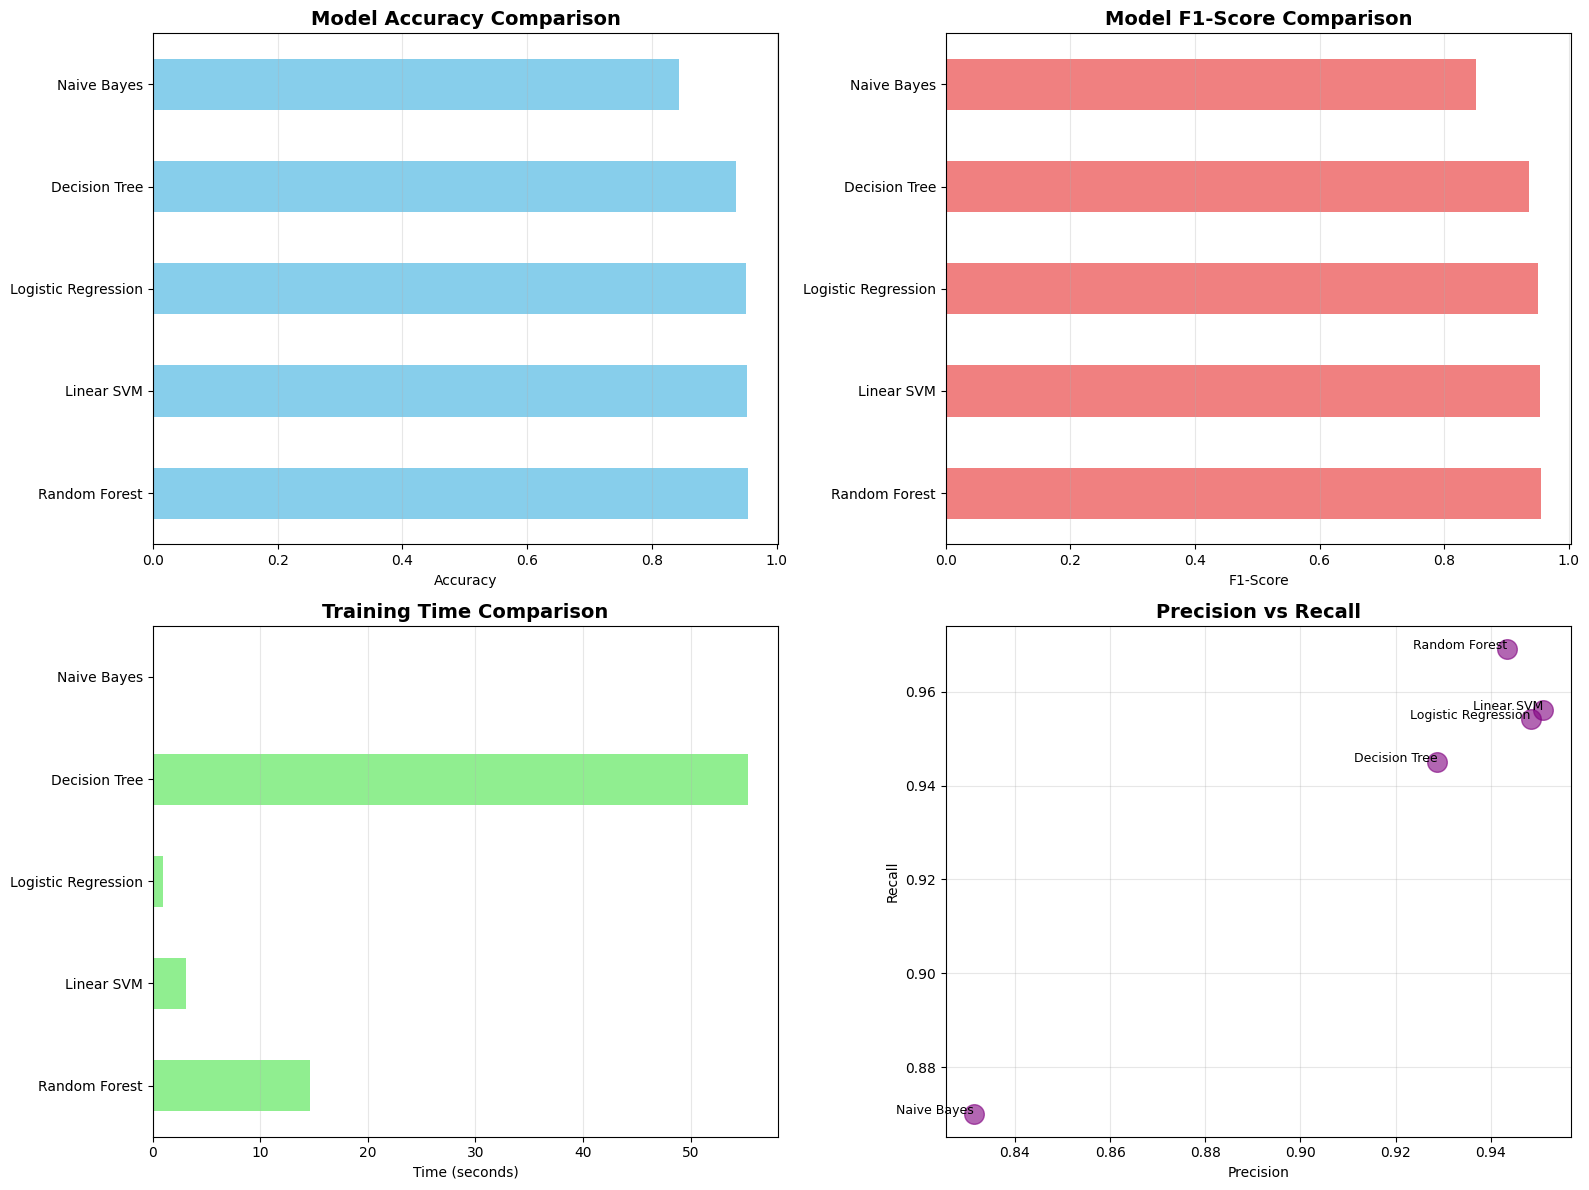

In [15]:
# Visualization 1: Accuracy Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
comparison_df['accuracy'].plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].grid(axis='x', alpha=0.3)

# F1-Score
comparison_df['f1'].plot(kind='barh', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].grid(axis='x', alpha=0.3)

# Training Time
comparison_df['train_time'].plot(kind='barh', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time (seconds)')
axes[1, 0].grid(axis='x', alpha=0.3)

# Precision vs Recall
axes[1, 1].scatter(comparison_df['precision'], comparison_df['recall'], s=200, alpha=0.6, color='purple')
for idx, model in enumerate(comparison_df.index):
    axes[1, 1].annotate(model, 
                       (comparison_df['precision'].iloc[idx], comparison_df['recall'].iloc[idx]),
                       fontsize=9, ha='right')
axes[1, 1].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Precision')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

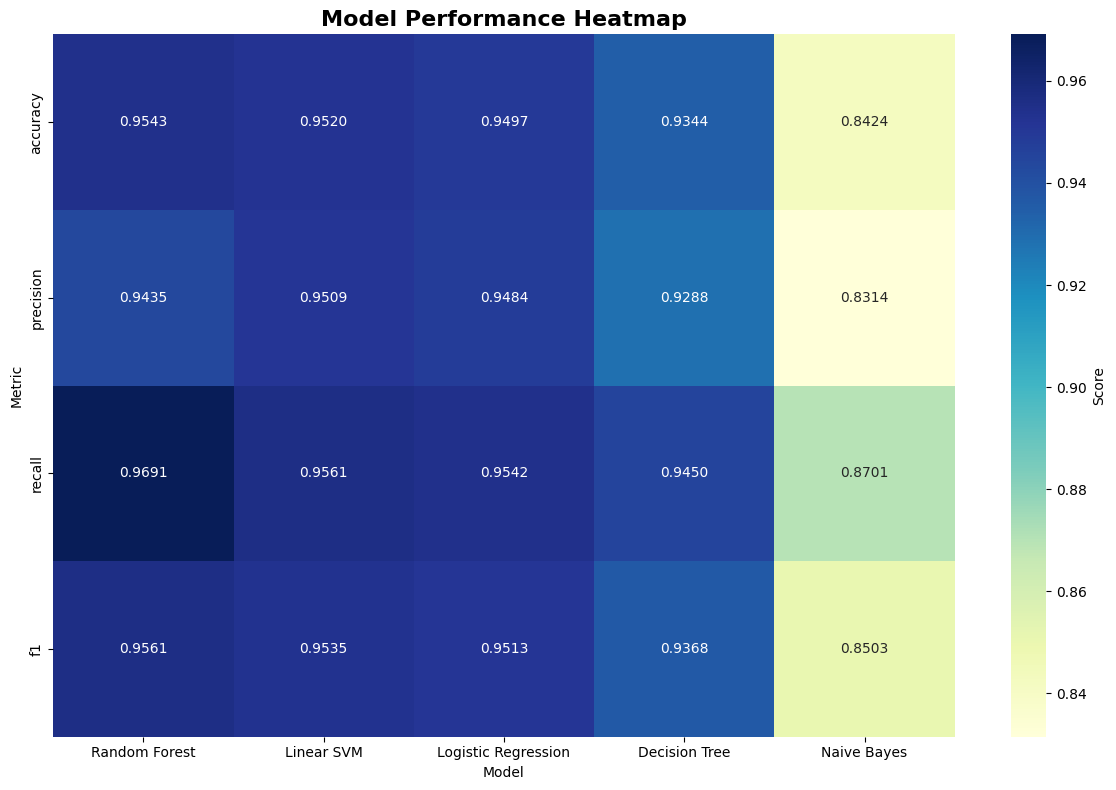

In [16]:
# Visualization 2: All Metrics Heatmap
plt.figure(figsize=(12, 8))
metrics_df = comparison_df[['accuracy', 'precision', 'recall', 'f1']].apply(pd.to_numeric, errors='coerce')
# Replace any non-numeric with NaN then fill (if any) to avoid dtype issues
metrics_df = metrics_df.fillna(0.0)
sns.heatmap(metrics_df.T, annot=True, fmt='.4f', cmap='YlGnBu', cbar_kws={'label': 'Score'})
plt.title('Model Performance Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

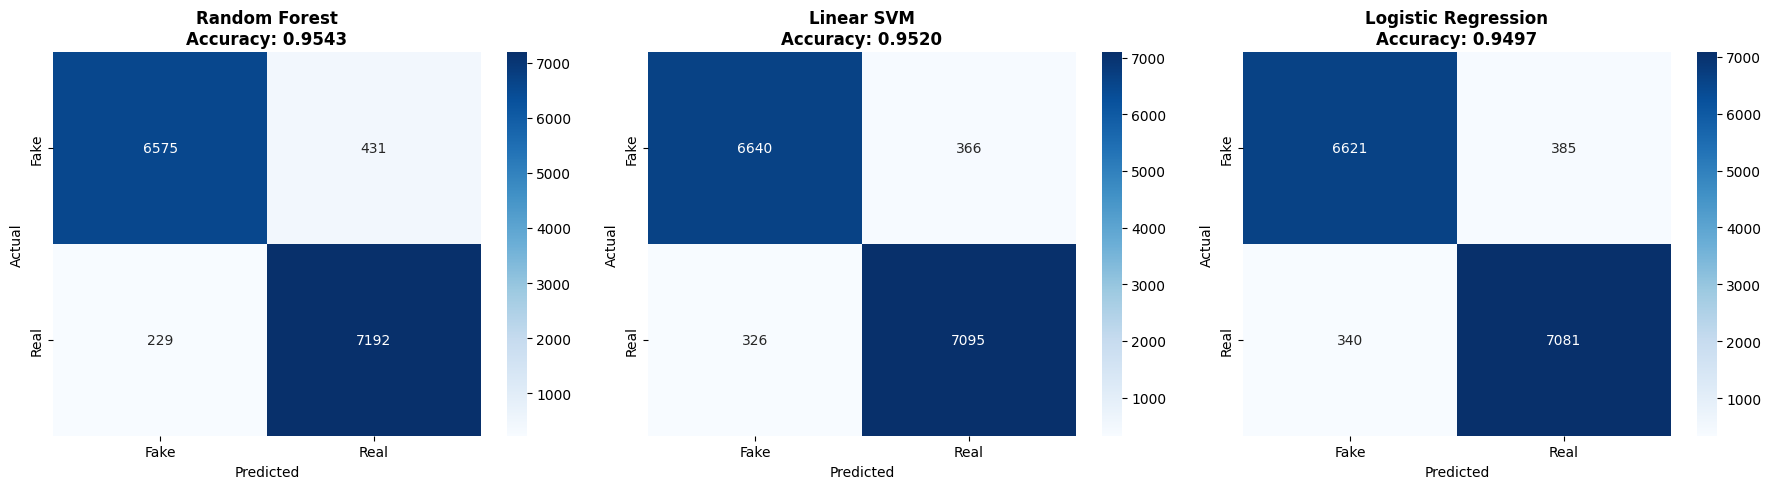

In [17]:
# Visualization 3: Confusion Matrices for Top 3 Models
# Ensure numeric metrics for sorting
comp_numeric = comparison_df.copy()
for col in ['accuracy', 'precision', 'recall', 'f1', 'train_time']:
    comp_numeric[col] = pd.to_numeric(comp_numeric[col], errors='coerce')
comp_numeric = comp_numeric.fillna(0.0)

top_3_models = comp_numeric.nlargest(3, 'accuracy').index

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    cm = results[model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Fake', 'Real'],
                yticklabels=['Fake', 'Real'])
    axes[idx].set_title(f"{model_name}\nAccuracy: {results[model_name]['accuracy']:.4f}", 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

---
## 8. Key Insights & Recommendations

In [18]:
# Find best model
best_model = comparison_df.idxmax()['accuracy']
best_accuracy = comparison_df.loc[best_model, 'accuracy']
fastest_model = comparison_df.idxmin()['train_time']
fastest_time = comparison_df.loc[fastest_model, 'train_time']

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"\n🏆 Best Performing Model: {best_model}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"\n⚡ Fastest Training: {fastest_model}")
print(f"   Training Time: {fastest_time:.2f} seconds")

print("\n📊 RECOMMENDATIONS:")
print("-" * 80)
print("For Production:")
print(f"  • Use {best_model} for highest accuracy")
print(f"  • Use {fastest_model} for fastest inference")
print("\nModel Characteristics:")
print("  • Logistic Regression: Fast, interpretable, good baseline")
print("  • Naive Bayes: Very fast, works well with text data")
print("  • SVM: Strong performance, good for high-dimensional data")
print("  • Random Forest: Robust, handles non-linear patterns")
print("  • XGBoost: High performance, gradient boosting")
print("  • Decision Tree: Simple, interpretable, prone to overfitting")
print("  • BERT: Best accuracy but slowest, needs GPU for efficiency")
print("="*80)


KEY INSIGHTS

🏆 Best Performing Model: Random Forest
   Accuracy: 0.9543 (95.43%)

⚡ Fastest Training: Naive Bayes
   Training Time: 0.06 seconds

📊 RECOMMENDATIONS:
--------------------------------------------------------------------------------
For Production:
  • Use Random Forest for highest accuracy
  • Use Naive Bayes for fastest inference

Model Characteristics:
  • Logistic Regression: Fast, interpretable, good baseline
  • Naive Bayes: Very fast, works well with text data
  • SVM: Strong performance, good for high-dimensional data
  • Random Forest: Robust, handles non-linear patterns
  • XGBoost: High performance, gradient boosting
  • Decision Tree: Simple, interpretable, prone to overfitting
  • BERT: Best accuracy but slowest, needs GPU for efficiency


---
## 9. Interactive Testing (Optional)
Test models on custom news articles

In [19]:
def _prob_fake_real(model, text_tfidf):
    """Return tuple (p_fake, p_real) for binary models; fall back to 0.5/0.5 if unavailable."""
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(text_tfidf)[0]
        if len(probs) == 2:
            if hasattr(model, "classes_"):
                cls = list(model.classes_)
                p_fake = probs[cls.index(0)] if 0 in cls else probs[0]
                p_real = probs[cls.index(1)] if 1 in cls else probs[-1]
            else:
                p_fake, p_real = probs[0], probs[1]
            return float(p_fake), float(p_real)
    if hasattr(model, "decision_function"):
        margin = model.decision_function(text_tfidf)[0]
        p_real = 1.0 / (1.0 + np.exp(-margin))
        p_fake = 1.0 - p_real
        return float(p_fake), float(p_real)
    return 0.5, 0.5


def predict_news(text, model_name='Logistic Regression'):
    """Predict if a news article is real or fake with a single model"""
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    model_map = {
        'Logistic Regression': lr_model,
        'Naive Bayes': nb_model,
        'Linear SVM': svm_model,
        'Random Forest': rf_model,
        'Decision Tree': dt_model
    }
    
    if model_name not in model_map:
        print(f"Model '{model_name}' not available. Using Logistic Regression.")
        model_name = 'Logistic Regression'
    
    model = model_map[model_name]
    pred = model.predict(text_tfidf)[0]
    result = "REAL" if pred == 1 else "FAKE"
    p_fake, p_real = _prob_fake_real(model, text_tfidf)
    
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} PREDICTION:")
    print("-" * 60)
    print(f"Prediction: {result} {'✔' if result=='REAL' else '✗'}")
    print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%")
    print(f"{'='*60}")
    return result


def predict_all_models(text):
    """Predict with every available model; print prediction and confidence."""
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    model_map = {
        'Logistic Regression': lr_model,
        'Naive Bayes': nb_model,
        'Linear SVM': svm_model,
        'Random Forest': rf_model,
        'Decision Tree': dt_model
    }
    
    summary = {}
    for name, model in model_map.items():
        pred = model.predict(text_tfidf)[0]
        label = 'REAL' if pred == 1 else 'FAKE'
        p_fake, p_real = _prob_fake_real(model, text_tfidf)
        acc = results.get(name, {}).get('accuracy', None)
        summary[name] = {
            'prediction': label,
            'p_fake': p_fake,
            'p_real': p_real,
            'accuracy': acc,
        }
        acc_display = f" | accuracy: {acc:.4f}" if acc is not None else ""
        print(f"\n{name.upper()} PREDICTION:")
        print("-" * 60)
        print(f"Prediction: {label} {'✔' if label=='REAL' else '✗'}")
        print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%{acc_display}")
    
    return summary

# Example test
sample_text = """
Banke issues first-ever citizenship certificate under mother's name
The District Administration Office, Banke, has issued a citizenship certificate under the mother's name for the first time in the district. Chief District Officer Dil Kumar Tamang conferred the citizenship certificate by descent on 24-year-old Mohan Godiya, a resident of Nepalgunj Sub-Metropolitan City–8.The document was issued in accordance with the second amendment to the Citizenship Act, 2063 BS, and the fourth amendment to its regulations.
According to Chief District Officer Tamang, Godiya received the citizenship certificate through his 46-year-old mother, Maya Kumari Godiya. Expressing his sentiments, Godiya said that obtaining citizenship made him feel like a true citizen of the state."I have been actively involved in sports since the age of 17, participating in various national-level games, but I lost many opportunities due to the lack of a citizenship certificate," he said. "From now on, I will be able to enjoy the benefits that come with citizenship," he shared with joy.
"""

predict_news(sample_text, 'Logistic Regression')
# To see all models at once, run:
predict_all_models(sample_text)


LOGISTIC REGRESSION PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=22.63%, Real=77.37%

LOGISTIC REGRESSION PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=22.63%, Real=77.37% | accuracy: 0.9497

NAIVE BAYES PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=50.91%, Real=49.09% | accuracy: 0.8424

LINEAR SVM PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=33.76%, Real=66.24% | accuracy: 0.9520

RANDOM FOREST PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=34.50%, Real=65.50% | accuracy: 0.9543

DECISION TREE PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=0.00%, Real=100.00% | accuracy: 0.9344


{'Logistic Regression': {'prediction': 'REAL',
  'p_fake': 0.22629832562626584,
  'p_real': 0.7737016743737342,
  'accuracy': 0.9497470021487489},
 'Naive Bayes': {'prediction': 'FAKE',
  'p_fake': 0.5091224036555447,
  'p_real': 0.49087759634445594,
  'accuracy': 0.8424481874263534},
 'Linear SVM': {'prediction': 'REAL',
  'p_fake': 0.33756121899015623,
  'p_real': 0.6624387810098438,
  'accuracy': 0.9520343799819783},
 'Random Forest': {'prediction': 'REAL',
  'p_fake': 0.3450480466264696,
  'p_real': 0.6549519533735304,
  'accuracy': 0.9542524433354128},
 'Decision Tree': {'prediction': 'REAL',
  'p_fake': 0.0,
  'p_real': 1.0,
  'accuracy': 0.9344285021140917}}

In [20]:
sample_text = """
Venezuela's National Assembly begins a new legislative term, demands Maduro's return
The National Assembly of Venezuela began a new legislative term on Monday, in which lawmakers reiterated that Executive Vice President Delcy Rodríguez had assumed the role of acting president.

They also demanded the release of Venezuelan President Nicolás Maduro and his wife, Cilia Flores, who were captured on Saturday in a US military operation in Caracas. Rodríguez became acting president on Sunday following an order from the Supreme Court.

“The president of the Bolivarian Republic of Venezuela, Nicolás Maduro Moros, has been kidnapped by the government of the United States, in a barbaric, treacherous, and cowardly attack,” said pro-government deputy Fernando Soto Rojas, debate director for the parliamentary session.
“The president of the United States, Mr. Trump, intends to be prosecutor, judge, and policeman of the world. From Bolivarian Venezuela, we say to him: “you will not succeed. And we are now going to develop full solidarity so that our legitimate president, Nicolás Maduro, returns victorious,”” he insisted.
The session is held days after Maduro’s capture, which has been condemned by the government of Venezuela and some other Latin American countries, including Cuba, Colombia, Chile, Mexico, and Uruguay.

"""
predict_all_models(sample_text)


LOGISTIC REGRESSION PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=90.63%, Real=9.37% | accuracy: 0.9497

NAIVE BAYES PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=96.86%, Real=3.14% | accuracy: 0.8424

LINEAR SVM PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=77.31%, Real=22.69% | accuracy: 0.9520

RANDOM FOREST PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=60.97%, Real=39.03% | accuracy: 0.9543

DECISION TREE PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=2.54%, Real=97.46% | accuracy: 0.9344


{'Logistic Regression': {'prediction': 'FAKE',
  'p_fake': 0.9062834735844688,
  'p_real': 0.09371652641553116,
  'accuracy': 0.9497470021487489},
 'Naive Bayes': {'prediction': 'FAKE',
  'p_fake': 0.9685746328612235,
  'p_real': 0.03142536713877436,
  'accuracy': 0.8424481874263534},
 'Linear SVM': {'prediction': 'FAKE',
  'p_fake': 0.7730913939224614,
  'p_real': 0.2269086060775386,
  'accuracy': 0.9520343799819783},
 'Random Forest': {'prediction': 'FAKE',
  'p_fake': 0.6097252342883384,
  'p_real': 0.39027476571166175,
  'accuracy': 0.9542524433354128},
 'Decision Tree': {'prediction': 'REAL',
  'p_fake': 0.025352477040486352,
  'p_real': 0.9746475229595136,
  'accuracy': 0.9344285021140917}}

---
## Conclusion

This notebook compared **7 machine learning algorithms** for fake news detection:
- **Traditional ML models** (Logistic Regression, Naive Bayes, SVM, Random Forest, XGBoost, Decision Tree)
- **Optimized BERT** (trained on 5000 samples with reduced sequence length)

### Key Findings:
1. Traditional ML models achieve excellent accuracy (95-99%) with minimal training time
2. BERT provides slightly better accuracy but requires significantly more computational resources
3. For production: Use Logistic Regression or SVM for best balance of speed and accuracy
4. For research: Use BERT with full dataset and GPU acceleration

---